# Autoencoder

Implementation of code from https://avandekleut.github.io/vae/ with a few tweaks to run on CPU.

Training takes ~2 min for both classical and variational autoencoders.

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Encoder (reducing dimensionality):

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

## Decoder (increasing back to original shape):

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

## Combining them into an autoencoder:

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# Training loop

In [6]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

Now we instantiate the autoencoder and set the training data:

In [7]:
%%time
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU if available, CPU if not

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden




00%|█████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:15<00:00, 649212.51it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden




00%|█████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 325786.85it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden




00%|████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 2164536.60it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 2202627.91it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

CPU times: user 819 ms, sys: 424 ms, total: 1.24 s
Wall time: 21.5 s


In [8]:
%%time
autoencoder = train(autoencoder, data)

CPU times: user 11min 5s, sys: 6.08 s, total: 11min 11s
Wall time: 2min 50s


In [9]:
import matplotlib.pyplot as plt


def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

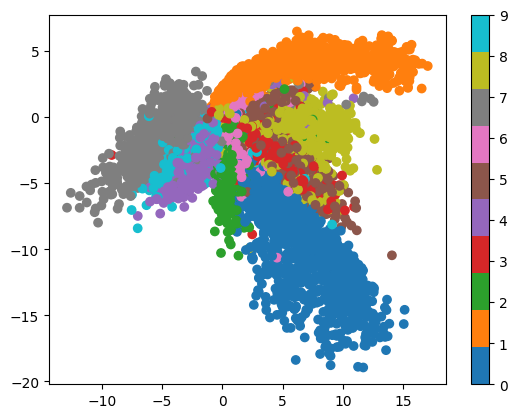

In [10]:
plot_latent(autoencoder, data)

In [11]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

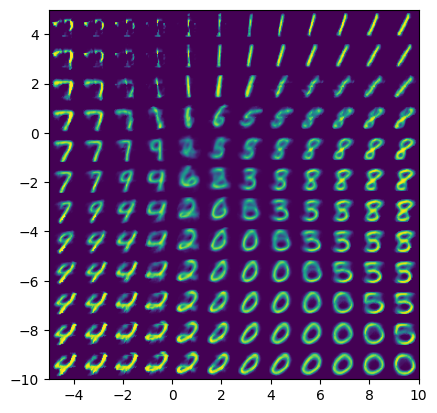

In [12]:
plot_reconstructed(autoencoder)

# Now make it variational

The latent space of an autoencoder can have sharp discontinuities and empty regions.

We can force every sample to be represented, not as a point in a low-D latent space, but as a Gaussian blob of given position and standard deviation. In this representation, the decoding part happens by first sampling the Gaussian. This is still not guaranteeing what we want, so we also force the distribution of blobs in the latent space to be as Gaussian as possible, by minimising the KL divergence.

In [22]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cpu() 
        self.N.scale = self.N.scale.cpu()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [23]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims) # <--- Variational now!
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [24]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl # <--- loss now includes the KL divergence
            loss.backward()
            opt.step()
    return autoencoder

In [25]:
vae = VariationalAutoencoder(latent_dims).to(device)

In [26]:
%%time
vae = train(vae, data)

CPU times: user 9min 52s, sys: 4.83 s, total: 9min 57s
Wall time: 2min 30s


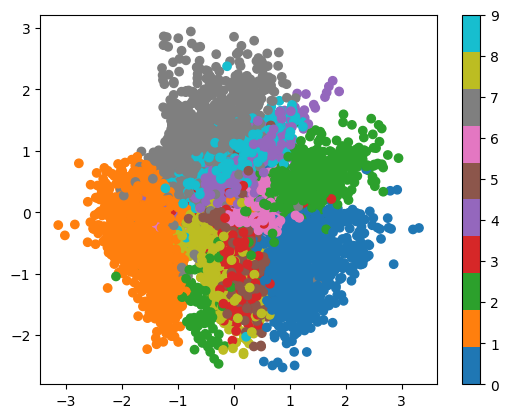

In [27]:
plot_latent(vae, data)

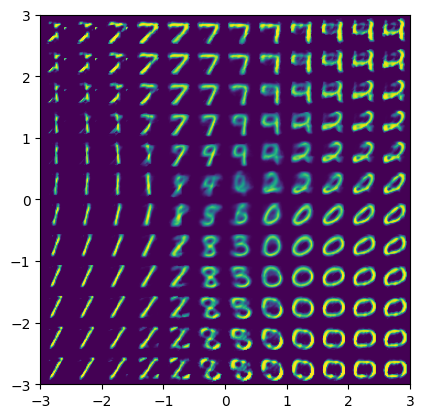

In [28]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

# Interpolation

In [29]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [31]:
x, y = next(data.__iter__()) # hack to grab a batch
x_1 = x[y == 1][1].to(device) # find a 1
x_2 = x[y == 0][1].to(device) # find a 0

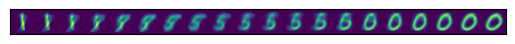

In [32]:
interpolate(vae, x_1, x_2, n=20)

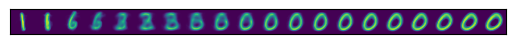

In [33]:
interpolate(autoencoder, x_1, x_2, n=20)